In [1]:
from pyedflib import highlevel
import numpy as np
from pylab import *
import csv
from scipy import signal
from scipy.signal import welch, butter, filtfilt, lfilter
import glob, os
import pyedflib
from PyEMD import EMD
import pandas as pd
import skimage
from scipy.stats import *
import pickle

basedir = os.getcwd()
# Put here the directory of the CHBMIT DATABASE
dbdir = r"F:\Master\TFM\chb-mit-scalp-eeg-database-1.0.0"

In [2]:
class Register:
    
    def __init__(self, name, fs, nseizures):
        self.name = name
        self.fs = fs
        self.nseizures = nseizures
        self.seizures = []
        self.channels = []
        self.ictaltime = 0
            
    def addSeizure (self, start, end):
        self.ictaltime += end - start
        seizure = [start, end]
        self.seizures.append(seizure)
        

def read_data(filename, channels=[]):
    f = pyedflib.EdfReader(filename)
    
    # if no channels are passed to the function
    if len(channels) == 0:
        channels = f.getSignalLabels()

    channel_names = f.getSignalLabels()
    fs = f.getSampleFrequencies()

    data = np.zeros((len(channels), f.getNSamples()[0]))
    for i, channel in enumerate(channels):
        data[i, :] = f.readSignal(channel_names.index(channel))
        
    time = np.linspace(0, data.shape[1]/fs[0], data.shape[1])
    f._close()
    return data, fs[0], time

def trunc(data, timeW, fs):
    samples = data.shape[1]
    N = timeW*fs
    nw = int(samples//N)

    data = data [:, 0:nw*N]
    time = np.linspace(0, data.shape[1]/fs, data.shape[1])
    return data, time, nw, N

def create_seizure_vector(seizures):
    seizure = zeros(samples)
    ict_end = 0
    for n in range (len(seizures)):
        pre_start = max(((seizures[n][0]- 300)*fs), 0, ict_end)   
        ict_start = seizures[n][0]*fs
        ict_end = seizures[n][1]*fs
        seizure[pre_start:ict_start] = np.ones(ict_start-pre_start)
        seizure[ict_start:ict_end] = np.ones(ict_end-ict_start) + 1

    seizureW = skimage.util.view_as_windows(seizure, N, N//2)
    seizureW = np.around(mean(seizureW, 1))
    return seizureW

In [3]:
def highpass(s, cutoff, fs, order = 5):
    b, a = signal.butter(order, cutoff / (fs/2), btype='high', analog=False)
    return filtfilt(b, a, s, axis = 1)

def lowpass(s, f, fs, order=5):
    b, a = signal.butter(order, f / (fs/2))
    return lfilter(b, a, s, axis = 1)

def frec2sample_range(fi, fo, fs, N):
    si = max(1,floor(fi*N/fs))
    so = ceil(fo*N/fs)
    return int(si), int(so)

def band_energy(fft, fs):
    N = len(fft)
    # Energia total
    et = sum(fft)
    dsi, dso = frec2sample_range(0.5, 4, fs, N)
    d = sum(fft[dsi:dso])
    tsi, tso = frec2sample_range(4, 7, fs, N)
    t = sum(fft[tsi:tso])
    asi, aso = frec2sample_range(7, 13, fs, N)
    a = sum(fft[asi:aso])
    bsi, bso = frec2sample_range(13, 30, fs, N)
    b = sum(fft[bsi:bso])
    gsi, gso = frec2sample_range(30, 50, fs, N)
    g = sum(fft[gsi:gso])
    return et, d, t, a, b, g

def psd(signal):
    X = fft(signal)
    Px = real(X*conj(X))
    return Px

def exponential_smooth(timeseries, alpha=0.3):
    model = SimpleExpSmoothing(timeseries)
    fit = model.fit(smoothing_level=alpha)
    return fit.fittedregisters

def spectral_centroid(nf, ps):
    return sum(nf * ps)

def variational_coeff(nf, ps, sc):
    return sum( (((nf - sc))**2) * ps) / sum(ps)

def spectral_skew(nf, ps, sc, vc):
    return sum( ((nf - sc)/vc)**3 * ps) / sum(ps)
   
def bandpower(freqs, psd, band, output = False):
    band = np.asarray(band)
    low, high = band
    
    # Find closest indices of band in frequency vector
    idx_min = np.argmax(np.round(freqs) > low) - 1
    idx_max = np.argmax(np.round(freqs) > high)
    # select frequencies of interest
    psd = sum(psd[idx_min:idx_max])

    return psd

def power_measures(data, sample_rate, output=False):
    bandpasses = [[[0.5,50],'power'],
                  [[0.5,4],'power_delta'],
                  [[4,8],'power_theta'],
                  [[8,13],'power_alpha'],
                  [[13,30],'power_beta'],
                  [[30,50],'power_gamma']]
    
    # Compute the periodogram (Welch)
    freqs, psd = welch(data, sample_rate, nperseg=(sample_rate*2), window='hamm', scaling='density', axis=0)
    
    bandpass_data = np.zeros(len(bandpasses))
    for i, [bandpass, freq_name] in enumerate(bandpasses):
        bandpass_data[i] = bandpower(freqs, psd, bandpass)
    return bandpass_data   
    

def channel_processing(channel_matrix, fs):
    
        ninstances = channel_matrix.shape[0]
        power_bands = zeros([ninstances, 6])

        meanv = zeros(ninstances)
        variancev = zeros(ninstances)
        skewnessv = zeros(ninstances)
        kurtosisv = zeros(ninstances)
        stdv = zeros(ninstances)
        zcrossingsv = zeros(ninstances)
        p2pv = zeros(ninstances)

        features = ['mean', 'variance', 'skewness', 'kurtosis', 'std', 'zero_crossings', 'peak2peak',
                    'total_energy', 'delta', 'theta', 'alpha', 'beta', 'gamma']

        for index, row in enumerate(channel_matrix):
            power_bands[index, :] = power_measures(row, fs)
            
            try:
                meanv[index] = mean(row)
                variancev[index] = var(row)
                skewnessv[index] = skew(row)
                kurtosisv[index] = kurtosis(row)
                stdv[index] = std(row)
                zcrossingsv[index] = len(np.where(np.diff(np.sign(row)))[0])
                p2pv[index] = max(row)-min(row)

            except ZeroDivisionError:
                meanv[index] = 0.001
                variancev[index] = 0.001
                skewnessv[index] = 0.001
                kurtosisv[index] = 0.001
                stdv[index] = 0.001
                zcrossingsv[index] = 0.001
                p2pv[index] = 0.001

        data = [(meanv),(variancev),   (skewnessv),
                  (kurtosisv),   (stdv),  (zcrossingsv),  (p2pv),
                  (power_bands[:, 0]),   (power_bands[:, 1]),   (power_bands[:, 2]),
                  (power_bands[:, 3]),   (power_bands[:, 4]),  (power_bands[:, 5])
        ]
        

        data = np.array(data).transpose()
        df = pd.DataFrame(data, columns = features)
        
        return df

In [4]:
def read_annotations(annotation):
    with open(annotation) as f:
        registers = {}
        channels_dict = {}
        nmontages = 1
        for line in f:
            if ("Data Sampling Rate" in line):
                line = line.split()
                fs = int(line[3]) 
                
            if ("Channel " in line):
                line = line.split()
                channel = line[2]
                if channel in channels_dict:
                    channels_dict.update({channel: channels_dict[channel]+1})
                else:
                    channels_dict[channel] = 1

            if ("Channels changed" in line):
                nmontages += 1
                
            elif ("File Name" in line):
                name = line.split()[2]
                while True:
                    newLine = f.readline()
                    if ("Number of Seizures" in newLine):
                        nseizures = int(newLine.split()[5])
                        register = Register(name, fs, nseizures)
                        if nseizures > 0:
                            for i in range(nseizures):
                                line1 = f.readline().split()
                                line2 = f.readline().split()
                                if (line1[3] == "Time:"):
                                    start = int(line1[4])
                                    end = int(line2[4])
                                else:
                                    start = int(line1[3])
                                    end = int(line2[3])
                                    
                                register.addSeizure(start, end)

                        registers[name] = register
                        break
    common_channels = []
    [common_channels.append(key) for key in channels_dict.keys() if channels_dict[key] == nmontages]
    channel_index = dict(zip( list(np.arange(len(common_channels))), common_channels ))
    return registers, channel_index

In [5]:
def get_best_channels(channelsdf, nchannels=2):
    
    list_of_rows = [list(row) for row in channelsdf.values]
    
    channel_score_dict = {}
    for i, elem in enumerate(list_of_rows[0]):
        channel_score_dict[elem] = i

    for row, rowlist in enumerate(list_of_rows[1:]):
        for i, elem in enumerate(rowlist):
            channel_score_dict[elem] = channel_score_dict[elem] + i

    sorted_channels = sorted(channel_score_dict, key=channel_score_dict.get)
    best_channels = sorted_channels[:nchannels]
    
    return best_channels

def get_expression(channels):
    expression = 'df['
    for channel in best_channels:
        expression +='(df[\'channel\'] == \'' + channel + '\')|'
    return expression[:-1] + ']'

In [75]:
patient = 'chb16'
decimationCoeff = 2
timeW = 4
nchannels = 1

os.chdir(basedir)
# Calculate most significant channels for patient
channelsdf = pd.read_csv('..\DataSetCreation\DataSetsDetection\\' + patient + '_channel_order.csv', delimiter=',')
best_channels = get_best_channels(channelsdf, nchannels)


fdir = dbdir + '\\' + patient
os.chdir(fdir)
annotation = glob.glob('*txt')
    
registers, channel_index = read_annotations(annotation[0])
nchannels = 1

In [76]:
f = open(dbdir + '\RECORDS-WITH-SEIZURES', 'r', encoding = 'utf-8')
seizure_files = f.read().split('\n')
seizure_files = list(map(lambda string: string[6:], seizure_files))
f.close()

print(os.getcwd())
patient_seizure_files = []
patient_non_seizure_files = []
patient_files = sorted(registers.keys())
for file in patient_files:
    if file in seizure_files:
        patient_seizure_files.append(file)
    else:
        patient_non_seizure_files.append(file)
patient_non_seizure_files = patient_non_seizure_files[:min(4, len(patient_seizure_files))]

patient_selected_files = patient_non_seizure_files + patient_seizure_files
patient_selected_files

F:\Master\TFM\chb-mit-scalp-eeg-database-1.0.0\chb16


['chb16_01.edf',
 'chb16_02.edf',
 'chb16_03.edf',
 'chb16_04.edf',
 'chb16_10.edf',
 'chb16_11.edf',
 'chb16_14.edf',
 'chb16_16.edf',
 'chb16_17.edf',
 'chb16_18.edf']

C:\Users\Mario\anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


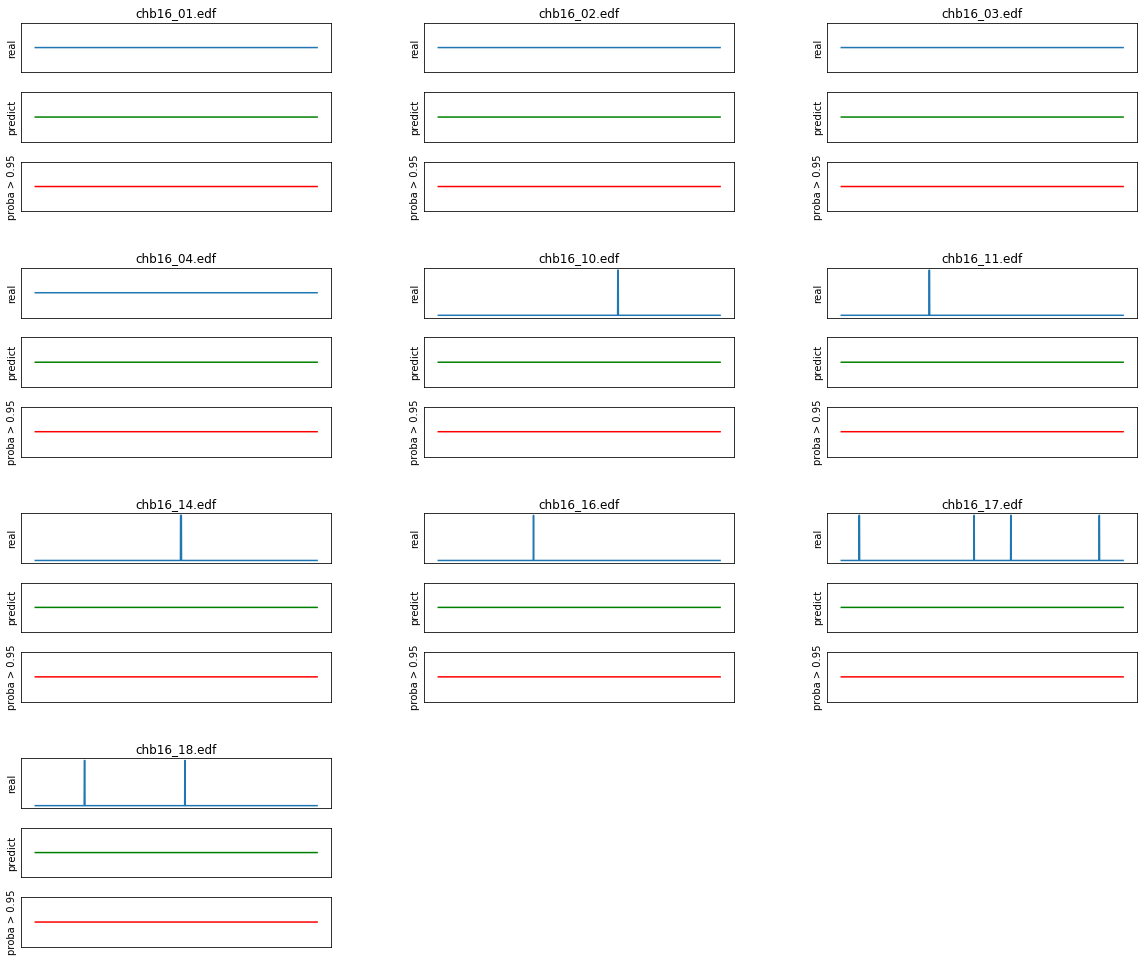

In [77]:
import matplotlib.gridspec as gridspec

threshold = 0.95

fig = plt.figure(figsize=(20, 17))
outer = gridspec.GridSpec(len(patient_selected_files)//3+1, 3, wspace=0.3, hspace=0.3)

i=0
for key, value in registers.items():
    
    if key in patient_selected_files:
        os.chdir(fdir)
        
        signals, originalfs, time = read_data(value.name, best_channels)
        # Decimation
        signals = signal.decimate(signals, decimationCoeff)
        fs = originalfs//decimationCoeff
        # Filtering 
        signals = highpass(signals, 0.5, fs)
        signals = lowpass(signals, 49, fs)

        # Truncate to generate time windows
        signals_trunc, time, nw, N = trunc(signals, timeW, fs)
        samples = signals_trunc.shape[1]

        # Seizure vector creation
        seizure = zeros(samples)
        for n in range (len(value.seizures)):
            start = value.seizures[n][0]*fs
            end = value.seizures[n][1]*fs
            seizure[start:end] = np.ones(end-start)

        seizureW = skimage.util.view_as_windows(seizure, N, N//2)
        seizureW = (sum(seizureW, 1) > N//2)

        # Create register dataframe
        auxdf = pd.DataFrame()
        for channel, s in enumerate(signals_trunc):
            # Only windows with preictal and ictal content
            newSignal = skimage.util.view_as_windows(s, N, N//2)
            nw = newSignal.shape[0]
            newdf = channel_processing(newSignal, fs)
            newdf['seizure'] = pd.Series( seizureW, index = newdf.index)
            
        x, y = newdf[newdf.columns.difference(['seizure'])], newdf["seizure"]
        
        os.chdir(basedir)
        model = pickle.load(open(basedir + '\\results_detection\\rnf_{}.sav'.format(patient), 'rb'))
        result_seizureW = model.predict(x)
        result_seizureW_proba = model.predict_proba(x)[:,1]>threshold
        
        #Plot inner grids
        inner = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=outer[i], wspace=0.4, hspace=0.4)
        ax = plt.Subplot(fig, inner[0])
        ax.plot(y)
        ax.set_ylabel('real')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(value.name)
        fig.add_subplot(ax)
        
        ax = plt.Subplot(fig, inner[1])
        ax.plot(result_seizureW, 'g')
        ax.set_ylabel('predict')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)
        
        ax = plt.Subplot(fig, inner[2])
        ax.plot(result_seizureW_proba, 'r')
        ax.set_ylabel('proba > {}'.format(threshold))
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)
            
        i += 1
        
fig.show()

### For just one register

In [30]:
patient = 'chb10'
decimationCoeff = 2
timeW = 4
nchannels = 1

os.chdir(basedir)
# Calculate most significant channels for patient
channelsdf = pd.read_csv('..\DataSetCreation\DataSetsDetection\\' + patient + '_channel_order.csv', delimiter=',')
best_channels = get_best_channels(channelsdf, nchannels)


fdir = dbdir + '\\' + patient
os.chdir(fdir)
annotation = glob.glob('*txt')
    
registers, channel_index = read_annotations(annotation[0])
nchannels = 1
register = registers['chb10_08.edf']

In [31]:
signals, originalfs, time = read_data(register.name, best_channels)
# Decimation
signals = signal.decimate(signals, decimationCoeff)
fs = originalfs//decimationCoeff
# Filtering 
signals = highpass(signals, 0.5, fs)
signals = lowpass(signals, 49, fs)
            
# Truncate to generate time windows
signals_trunc, time, nw, N = trunc(signals, timeW, fs)
samples = signals_trunc.shape[1]

# Seizure vector creation
seizure = zeros(samples)
for n in range (len(register.seizures)):
    start = register.seizures[n][0]*fs
    end = register.seizures[n][1]*fs
    seizure[start:end] = np.ones(end-start)

seizureW = skimage.util.view_as_windows(seizure, N, N//2)
seizureW = (sum(seizureW, 1) > N//2)

# Create register dataframe
auxdf = pd.DataFrame()
for channel, s in enumerate(signals_trunc):
    # Only windows with preictal and ictal content
    newSignal = skimage.util.view_as_windows(s, N, N//2)
    nw = newSignal.shape[0]
    newdf = channel_processing(newSignal, fs)
    newdf['seizure'] = pd.Series( seizureW, index = newdf.index)

In [32]:
x, y = newdf[newdf.columns.difference(['seizure'])], newdf["seizure"]

In [34]:
os.chdir(basedir)
model = pickle.load(open(basedir + '\\results_detection\\rnf_{}.sav'.format(patient), 'rb'))
result_seizureW = model.predict(x)

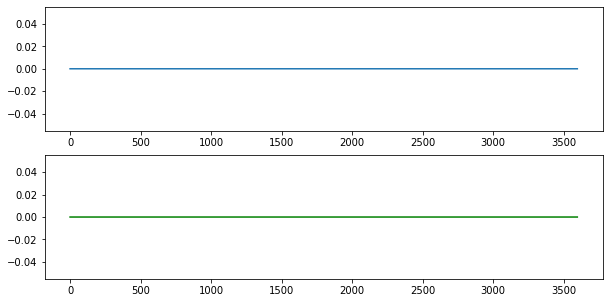

In [35]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()
plt.figure(figsize=(10,5))

plt.subplot(2,1,1)
plot(y)
plt.subplot(2,1,2)
plot(result_seizureW, 'g')